# Trying some models and features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

In [2]:
# import data
data = pd.read_csv (r'bank-additional.csv', sep = ';', engine= 'python')
data = data.head(1000)
length = data.shape[0]
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
length

1000

## Select the variables to be used in the model

In [5]:
# select variables
cats_to_use = ['age', 'month', 'poutcome', 'emp.var.rate', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

In [6]:
data

,age,month,poutcome,emp.var.rate,y
0,30,may,nonexistent,-1.8,no
1,39,may,nonexistent,1.1,no
2,25,jun,nonexistent,1.4,no
3,38,jun,nonexistent,1.4,no
4,47,nov,nonexistent,-0.1,no
...,...,...,...,...,...
995,37,nov,failure,-0.1,no
996,30,nov,nonexistent,-0.1,no
997,33,may,nonexistent,1.1,yes
998,36,may,nonexistent,1.1,no


In [7]:
data.columns

Index(['age', 'month', 'poutcome', 'emp.var.rate', 'y'], dtype='object')

In [8]:
data.nunique()

age             54
month           10
poutcome         3
emp.var.rate     9
y                2
dtype: int64

## Create basetable from data

In [9]:
# name of base table
base = data

# replace cat. and dep variables by their dummy matrices
base = pd.get_dummies(base, drop_first=True)

# rename dependent variable as y
base.rename(columns={'y_yes': 'y'}, inplace=True)

base

,age,emp.var.rate,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,y
0,30,-1.8,0,0,0,0,0,1,0,0,0,1,0,0
1,39,1.1,0,0,0,0,0,1,0,0,0,1,0,0
2,25,1.4,0,0,0,1,0,0,0,0,0,1,0,0
3,38,1.4,0,0,0,1,0,0,0,0,0,1,0,0
4,47,-0.1,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37,-0.1,0,0,0,0,0,0,1,0,0,0,0,0
996,30,-0.1,0,0,0,0,0,0,1,0,0,1,0,0
997,33,1.1,0,0,0,0,0,1,0,0,0,1,0,1
998,36,1.1,0,0,0,0,0,1,0,0,0,1,0,0


In [10]:
base.columns

Index(['age', 'emp.var.rate', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_nonexistent', 'poutcome_success', 'y'],
      dtype='object')

## Create model

In [11]:
# Boosting the tree and predicting with ROC curve and classification reports
def gradient_boosted_tree(features, targets):
    train_features, test_features, train_targets, test_targets = train_test_split(features, targets.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
    ensemble = GradientBoostingClassifier(max_depth=1, n_estimators=1000 ,random_state=23).fit(
        train_features, train_targets)
    predictions = ensemble.predict(test_features)
    
    k = 10
    kf = KFold(n_splits=k, shuffle = True, random_state = 23)

    dt_scores = cross_val_score(ensemble, train_features, train_targets, scoring ='accuracy' ,cv = kf)
    print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))
    print("score without cv: {}".format(np.round(ensemble.score(train_features, train_targets),3)))
    
    #print(r2_score(test_targets, predictions))
    #print(ensemble.score(test_features, test_targets))
    
    print("Confusion Matrix:")
    print(confusion_matrix(test_targets, predictions))

    print("Classification Report")
    print(classification_report(test_targets, predictions))
    
    #Beginning the plotting of ROC-curve
    pred_prob = ensemble.predict_proba(test_features)
    fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
    #Plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Boosted Trees')

    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    #AUC Score
    auc_score = roc_auc_score(test_targets, pred_prob[:,1])
    print("AUC Score: " + str(np.round(auc_score , 3)))
    
    #Log-loss function
    print("Log-Loss: " + str(np.round(log_loss(test_targets, predictions),3)))

mean cross validation score: 0.911
score without cv: 0.925
Confusion Matrix:
[[173   3]
 [ 18   6]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       176
           1       0.67      0.25      0.36        24

    accuracy                           0.90       200
   macro avg       0.79      0.62      0.65       200
weighted avg       0.88      0.90      0.87       200



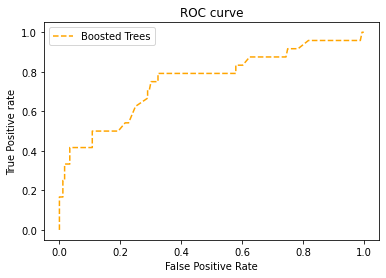

AUC Score: 0.753
Log-Loss: 3.627


In [12]:
y = base[['y']]
features = base.drop(columns=['y'])
gradient_boosted_tree(features, y)